In [292]:
import pandas as pd
import numpy as np


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse,rmse

from pandas_profiling import ProfileReport

from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 5)

from sklearn.model_selection import KFold

import warnings

warnings.filterwarnings("ignore")

In [448]:
def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []
    target = formula.split("~")[0].strip()

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)

        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train[target], model.predict(data_train)],
            axis=1,
            keys=[target, "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test[target], model.predict(data_test)],
            axis=1,
            keys=[target, "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr[target], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te[target], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse_test"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = [
        "Fold" + str(x + 1) + " rmse on test" for x in range(len(cvlist[0]["rmse"]))
    ]
    result = result.set_index("Resample")
    result = pd.concat(
        [result, pd.DataFrame(result.mean(), columns=["Average RMSE on test"]).T]
    )
    return result

def price_diff_by_variables2(df, factor_var, dummy_var):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=(target, np.mean), sd=(target, np.std), size=(target, "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Wage")
        + xlab(factor_var)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

In [294]:
data = pd.read_csv("../data/cps-earnings/clean/morg-2014-emp.csv",index_col = 0)

In [295]:
data.columns

Index(['hhid', 'intmonth', 'stfips', 'weight', 'earnwke', 'uhours', 'grade92',
       'race', 'ethnic', 'age', 'sex', 'marital', 'ownchild', 'chldpres',
       'prcitshp', 'state', 'ind02', 'occ2012', 'class', 'unionmme',
       'unioncov', 'lfsr94'],
      dtype='object')

 Selecting:
 - Computer programmers 1010
 - Software developers, applications and systems software 1020
 - Web developers 1030

In [474]:
work = data.loc[lambda x: x["occ2012"].isin([1010,1020,1030])]

Dropping household id and month of questionary and weight - for sure I dont need these variables

In [475]:
work = work.drop(["hhid","intmonth","weight"],axis=1)

In [476]:
work.isnull().sum()

stfips         0
earnwke        0
uhours         0
grade92        0
race           0
ethnic      1977
age            0
sex            0
marital        0
ownchild       0
chldpres       0
prcitshp       0
state          0
ind02          0
occ2012        0
class          0
unionmme       0
unioncov      55
lfsr94         0
dtype: int64

# Feature engineering

## Target variable

In [477]:
work["w"] = work["earnwke"] / work["uhours"]
work["lnw"] = np.log(work["w"])

## Continous variables

### 1. age

In [478]:
work["agesq"] = np.power(work["age"], 2)

### 2. education

Calculate years spend in education to get experience later

In [479]:
work["edu"] = work["grade92"]

In [480]:
work["edu"].value_counts().sort_index()

36       1
37       2
38       2
39      71
40     184
41      60
42      98
43    1098
44     505
45       9
46      37
Name: edu, dtype: int64

In [481]:
work["years_in_edu"] = work["edu"].map(
    {
        36: 10,
        37: 11,
        38: 12,
        39: 12,
        40: 13,
        41: 15,
        42: 15,
        43: 15,
        44: 17,
        45: 17,
        46: 22,
    }
)

## Categorical variables

### 0. create categorical from education

In [482]:
work["edu"] = np.where(
    work["edu"] < 43,
    "no degree",
    np.where(
        work["edu"] == 43,
        "BA degree",
        np.where((work["edu"] == 44) | (work["edu"] == 45), "MA degree", "Phd degree"),
    ),
)

In [483]:
work["edu"].value_counts()

BA degree     1098
MA degree      514
no degree      418
Phd degree      37
Name: edu, dtype: int64

### 1. race

In [484]:
work.race.value_counts()

1     1443
4      487
2       97
8       16
3        8
5        6
7        5
6        2
11       1
13       1
17       1
Name: race, dtype: int64

I decode race based on pdf as: 1:"white" 2:"black" 4:"asian" else:"other"

In [485]:
work["race"] = np.where(
    work["race"] == 1,
    "white",
    np.where(
        work["race"] == 2,
        "black",
        np.where(work["race"] == 4, "asian", "other"),
    ),
)

### 2. gender

In [486]:
work["sex"] = work.sex.map({1:"male",2:"female"})

### 3. marital

In [487]:
work.marital.value_counts().sort_index()

1    1306
2       4
3      35
4      13
5     133
6      24
7     552
Name: marital, dtype: int64

In [488]:
work["marital_status"] = np.where(
    work["marital"].isin([1, 2, 3]),
    "married",
    np.where(work["marital"].isin([4, 5, 6]), "used to be married", "never married"),
)

### 4. union

In [489]:
work["union"] = ((work["unionmme"] == "Yes") | (work["unioncov"] == "Yes")).astype(int)

### 5. children

In [490]:
work.ownchild.value_counts().sort_index()

0    1236
1     344
2     367
3      97
4      14
5       4
6       3
7       1
9       1
Name: ownchild, dtype: int64

In [491]:
work["n_children"] = np.where(work["ownchild"]>=3,"3>=",work["ownchild"].astype("str"))

### 6. employment status

In [492]:
work["emp_status"] = work.lfsr94

work.emp_status.value_counts()

Employed-At Work    2023
Employed-Absent       44
Name: emp_status, dtype: int64

### 7. class

In [493]:
work["working_class"] = work["class"]
work["working_class"].value_counts()

Private, For Profit     1796
Private, Nonprofit        92
Government - Federal      81
Government - State        74
Government - Local        24
Name: working_class, dtype: int64

### 8. occupation

In [494]:
work["occup"] = work["occ2012"].astype("category")
work["occup"].value_counts()

1020    1335
1010     516
1030     216
Name: occup, dtype: int64

### 9. industry

In [495]:
work["ind02"].value_counts().head(20)

Computer systems design and related services (5415)                                    727
Insurance carriers and related activities (524)                                         93
Colleges and universities, including junior colleges (6112, 6113)                       71
Management, scientific, and technical consulting services (5416)                        53
Electronic component and product manufacturing, n.e.c. (3344, 3346)                     53
Architectural, engineering, and related services (5413)                                 48
Banking and related activities (521, 52211,52219)                                       46
Hospitals (622)                                                                         42
3365                                                                                    38
Securities, commodities, funds, trusts, and other financial investments (523, 525)      37
National security and international affairs (928)                                       33

In [496]:
work["industry"] = work["ind02"]

work["industry"] = np.where(
    work["industry"] == "Computer systems design and related services (5415)",
    "Computer systems design",
    "Other",
)

work["industry"].value_counts()

Other                      1340
Computer systems design     727
Name: industry, dtype: int64

### 10. state

Lof of states, probably won't use it.

In [497]:
work["state"] = work["stfips"]

### 11. non-USborn

In [498]:
work.prcitshp.value_counts()

Native, Born In US                        1445
Foreign Born, Not a US Citizen             323
Foreign Born, US Cit By Naturalization     263
Native, Born Abroad Of US Parent(s)         29
Native, Born in PR or US Outlying Area       7
Name: prcitshp, dtype: int64

In [499]:
work["nonUSborn"] = (
    (work["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (work["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

In [500]:
data_clean = work.filter(
    [
        "w",
        "lnw",
        "age",
        "agesq",
        "exp",
        "expsq",
        "sex",
        "race",
        "edu",
        "years_in_edu",
        "marital_status",
        "n_children",
        "union",
        "emp_status",
        "working_class",
        "occup",
        "industry",
        "nonUSborn",
    ]
)

### + addigional features

### experience



In [501]:
data_clean["exp"] = data_clean["age"] - data_clean["years_in_edu"] - 6
data_clean["expsq"] = data_clean["exp"]**2

In [502]:
data_clean[["age","exp"]].corr()

,age,exp
age,1.000000,0.989701
exp,0.989701,1.000000


This might be a problem, will decide age vs exp to use.

In [503]:
data_clean.to_pickle("../data/clean.pkl")

## Descriptive statistics

In [504]:
data_clean = pd.read_pickle("../data/clean.pkl")

profile = ProfileReport(work, title="CPS-earnings", explorative=True)

profile.to_file("cps_report.html")

variable types

In [505]:
target = "w"
continous = ["age", "agesq", "exp", "expsq"]

categorical = [
    "sex",
    "race",
    "edu",
    "marital_status",
    "n_children",
    "union",
    "emp_status",
    "working_class",
    "occup",
    "industry",
    "nonUSborn",
]

<AxesSubplot:>

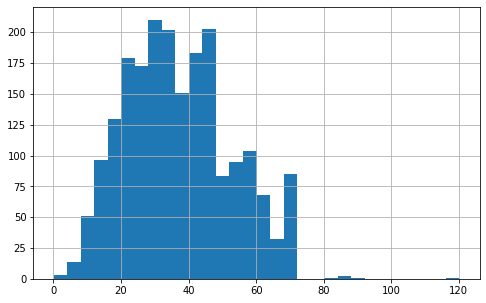

In [506]:
data_clean[target].hist(bins=30)

<AxesSubplot:xlabel='age', ylabel='w'>

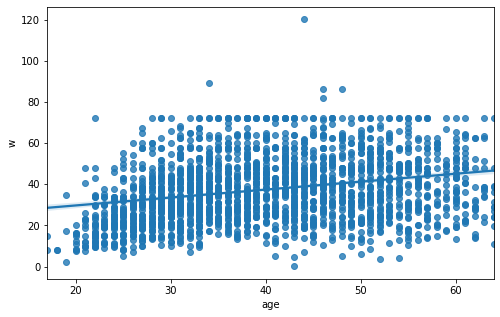

In [366]:
sns.regplot(y=target,x="age",data=data_clean)

<AxesSubplot:xlabel='exp', ylabel='w'>

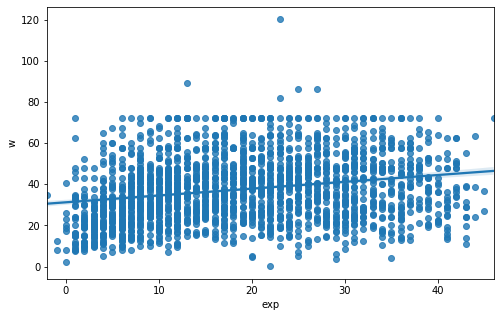

In [367]:
sns.regplot(y=target,x="exp",data=data_clean)

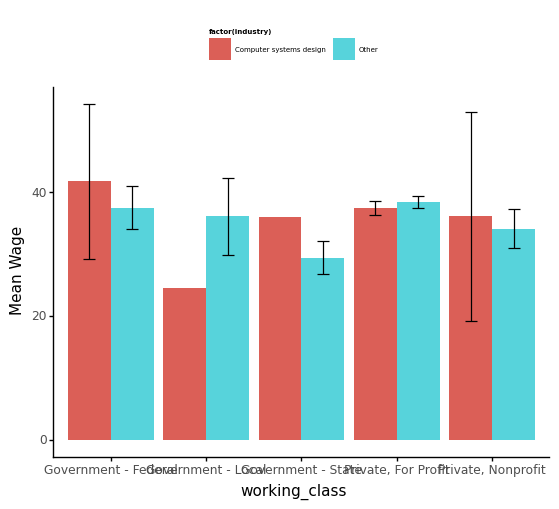

<ggplot: (326663334)>

In [442]:
price_diff_by_variables2(data_clean,categorical[7],categorical[9])

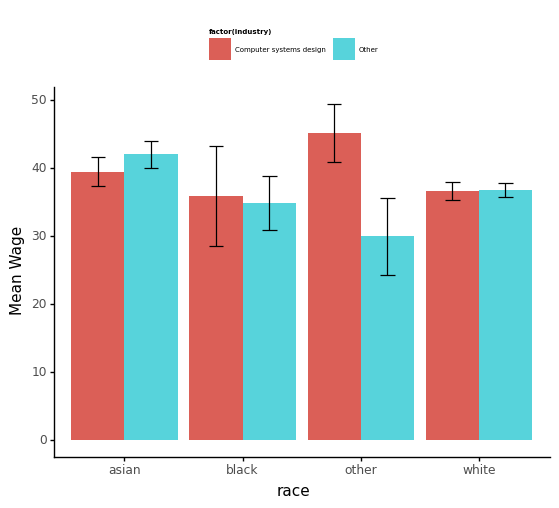

<ggplot: (325519219)>

In [404]:
price_diff_by_variables2(data_clean,categorical[1],categorical[9])

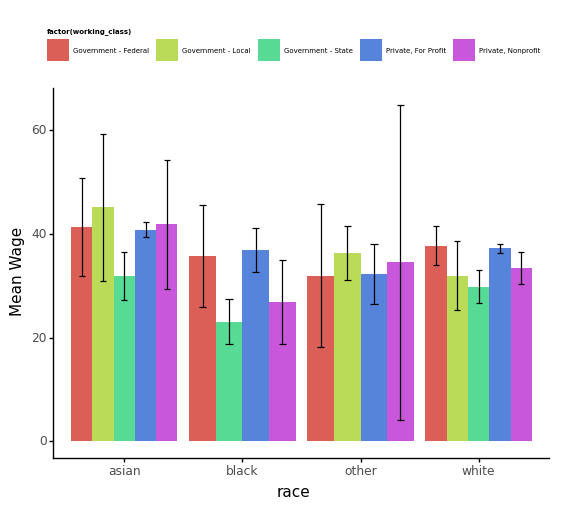

<ggplot: (325586622)>

In [402]:
price_diff_by_variables2(data_clean,categorical[1],categorical[7])

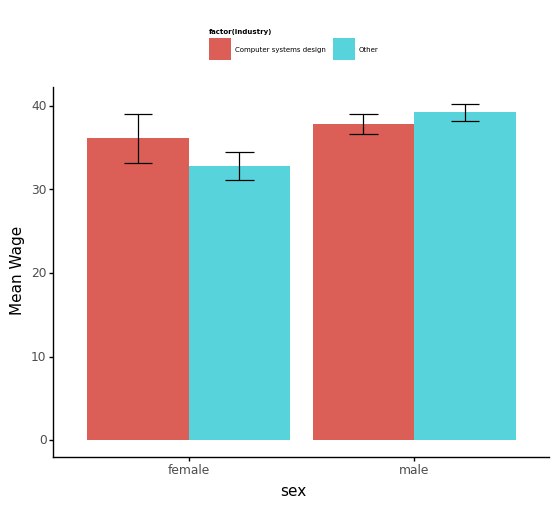

<ggplot: (325586637)>

In [394]:
price_diff_by_variables2(data_clean,categorical[0],categorical[9])

In [546]:
suggested_interactions = (
    "+"
    + "*".join((categorical[1], categorical[7]))
    + "+"
    + "*".join((categorical[0], categorical[9]))
    + "+"
    + "*".join((categorical[1], categorical[9]))
    + "+"
    + "*".join((categorical[7], categorical[9]))
)

## Model estimation

 equations to estimate

In [547]:
model1 = target + "~" + "age + agesq"
model2 = target + "~" + "+".join(continous + categorical)
model3 = target + "~" + "+".join(continous + categorical) + suggested_interactions
model4 = (
    target
    + "~"
    + "+".join(continous + categorical)
    + "+("
    + "+".join(continous)
    + ")*("
    + "+".join(categorical)
    + ")"
)

models = [model1, model2, model3, model4]

fit models on full sample

In [548]:
model_fits = [smf.ols(model, data_clean).fit() for model in models]

## Results

get BIC

In [549]:
model_bics = [model_fit.bic for model_fit in model_fits]

get RMSE on full sample

In [550]:
model_rmses = [
    rmse(model_fit.predict(data_clean), data_clean[target]) for model_fit in model_fits
]

do cross validation and get test set average RMSE-s

In [551]:
k = KFold(n_splits=4, shuffle=False, random_state=42)

cv_list = [cv_reg(model, data_clean, k) for model in models]
avg_rmse = summarize_cv(cv_list)

 display results in a table

In [552]:
results = pd.concat(
    [
        pd.DataFrame(
            data=[model_bics, model_rmses],
            columns=["Model" + str(i + 1) for i in range(len(models))],
        ).rename({1: "RMSE on full sample", 0: "BIC on full sample"}, axis=0),
        avg_rmse,
    ]
).round(2)
results

,Model1,Model2,Model3,Model4
BIC on full sample,17064.73,16925.25,17040.16,17462.10
RMSE on full sample,14.93,13.81,13.73,13.52
Fold1 rmse on test,14.93,13.78,13.86,14.09
Fold2 rmse on test,14.74,14.02,14.07,14.80
Fold3 rmse on test,14.99,14.32,14.35,14.64
Fold4 rmse on test,15.24,13.93,13.89,14.22
Average RMSE on test,14.97,14.01,14.04,14.44


 plot relationship of model complexity and model performance

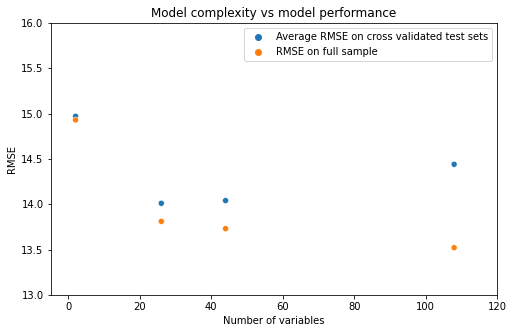

In [553]:
plot_results = pd.DataFrame(
    {
        "Average RMSE on cross validated test sets": results.loc[
            "Average RMSE on test", :
        ],
        "RMSE on full sample": results.loc["RMSE on full sample", :],
        "Number of variables": [cv["nvars"] for cv in cv_list],
    }
).melt(
    value_vars=["Average RMSE on cross validated test sets", "RMSE on full sample"],
    id_vars=["Number of variables"],
)

sns.scatterplot(x="Number of variables", y="value", hue="variable", data=plot_results)
plt.legend(title=None)
plt.ylabel("RMSE")
plt.ylim(13, 16)
plt.xlim(-5, 120)
plt.title("Model complexity vs model performance")
plt.show()